In [613]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import cross_val_score as CV
from xgboost import XGBRegressor


%matplotlib inline

In [538]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

In [539]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [540]:
def bar_sub(x=None):

    print(data[x].value_counts())
    plt.subplot(1,2,1)
    sns.countplot(data=data, x=x, order=data[x].value_counts().index)
    plt.xticks(rotation=90)

    plt.subplot(1,2,2);
    plt.pie(data[x].value_counts(), labels=data[x].value_counts().index,autopct='%1.1f%%',);
    plt.show();


male      676
female    662
Name: sex, dtype: int64


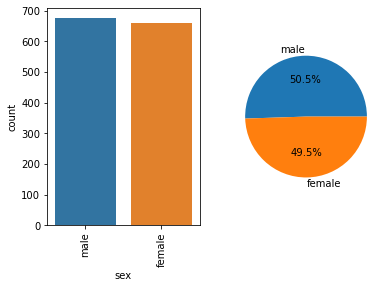

In [541]:
bar_sub('sex')

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


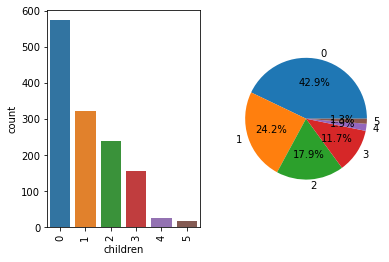

In [542]:
bar_sub('children')

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


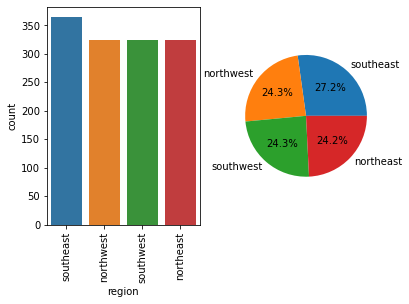

In [543]:
bar_sub('region')

no     1064
yes     274
Name: smoker, dtype: int64


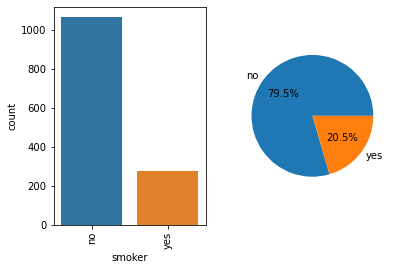

In [544]:
bar_sub('smoker')

In [545]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


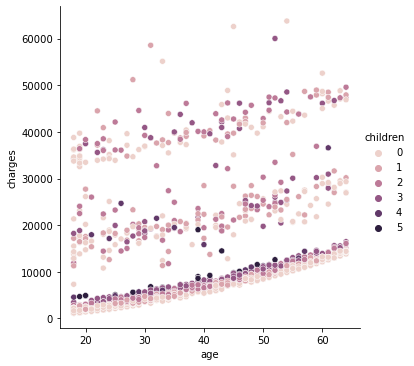

In [546]:
sns.relplot(data=data, x='age', y='charges', hue='children')

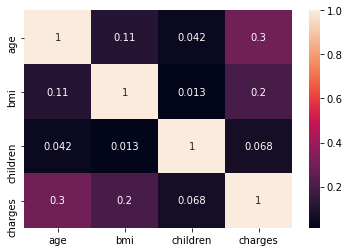

In [547]:
corr= data.corr()
sns.heatmap(corr, annot=True);

In [548]:
data_grouped=data.groupby(['smoker', 'sex']).agg({'charges':'sum','sex':'count'})
data_grouped

charges  sex
smoker sex                      
no     female  4.792977e+06  547
       male    4.181085e+06  517
yes    female  3.528085e+06  115
       male    5.253679e+06  159

In [549]:
df = pd.get_dummies(data=data, drop_first=True)
df.head(5)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


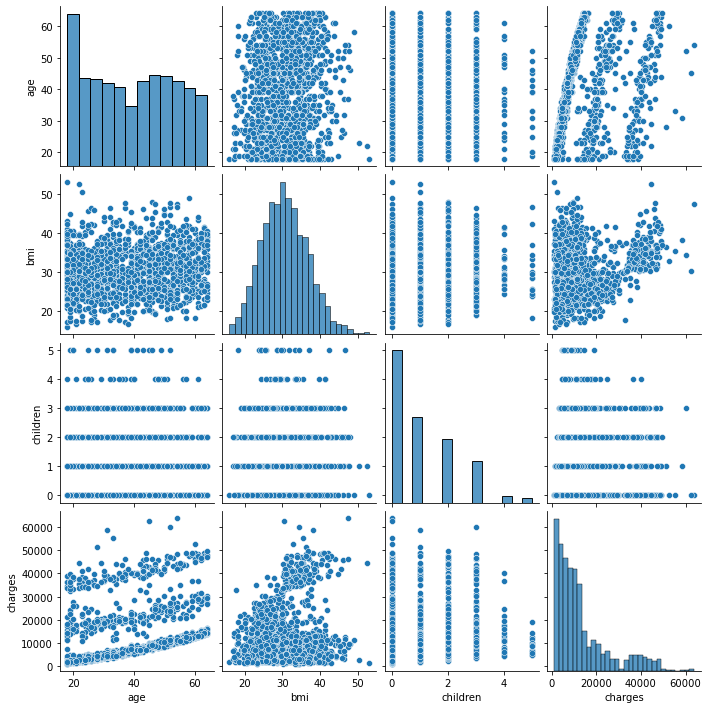

In [550]:
sns.pairplot(data=data)

Skewness 1.516 & mean 13270.422


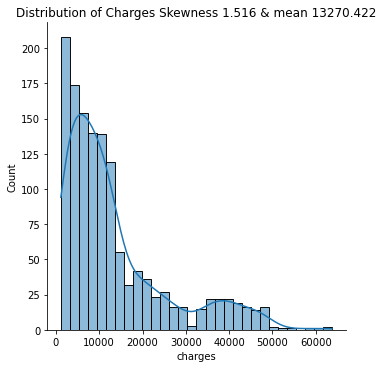

In [551]:
skew = round(data['charges'].skew(), 3)
mean = round(data['charges'].mean(), 3)
sns.displot(data['charges'], kde=True);
plt.title(f'Distribution of Charges Skewness {skew} & mean {mean}');
print(f'Skewness {skew} & mean {mean}' );


Skewness -0.09 & mean 9.099


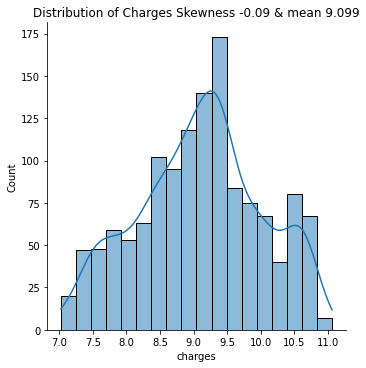

In [552]:
log_charge = np.log(data['charges'])
log_skew = round(log_charge.skew(), 3)
log_mean = round(log_charge.mean(), 3)

sns.displot(log_charge, kde=True);
plt.title(f'Distribution of Charges Skewness {log_skew} & mean {log_mean}');
print(f'Skewness {log_skew} & mean {log_mean}' );


# original model with original charge

In [553]:
# original model with original charge
features = df.drop(['charges'], axis=1)
charges = df['charges']
X_train, X_test, y_train, y_test = train_test_split(features, charges, random_state=23,
                                                   test_size=0.2)
# using sklearn
regr = LinearRegression()
regr.fit(X_train,y_train)
print('Intercept', regr.intercept_)
print('Train score',regr.score(X_train,y_train))
print('Test score',regr.score(X_test,y_test))

Intercept -11274.714608120852
Train score 0.7493255146273343
Test score 0.7536440382001555


In [554]:
# using stats model
X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()
print('Results r-squared ', results.rsquared)
print('BIC ', results.bic) 


Results r-squared  0.7493255146273343
BIC  21747.225872941563


In [555]:
pd.DataFrame({'coef':results.params,'p-values':round(results.pvalues, 3)})

,coef,p-values
const,-11274.714608,0.000
age,244.581639,0.000
bmi,338.444612,0.000
children,511.869435,0.001
sex_male,-93.045165,0.804
smoker_yes,24000.548124,0.000
region_northwest,-545.567916,0.307
region_southeast,-1238.683849,0.022
region_southwest,-1494.972657,0.006


# Residuals & Residual Plots

In [556]:
y_train.corr(results.fittedvalues)

0.8656359018821562

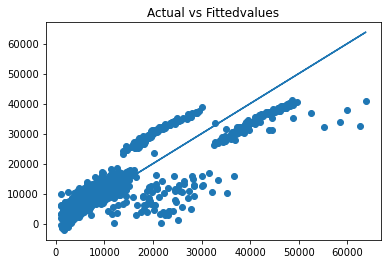

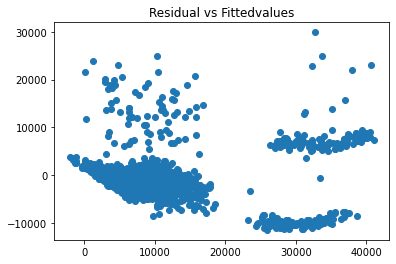

Text(0.5, 1.0, 'Skew 1.1844031564650412')

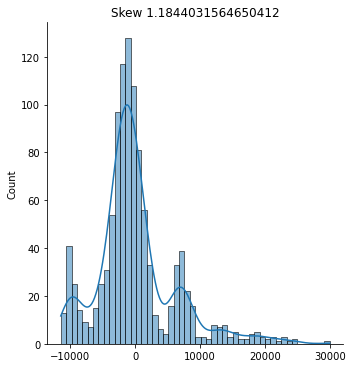

In [557]:
# actual vs predicted
plt.scatter(x=y_train, y=regr.predict(X_train));
plt.plot(y_train,y_train);
plt.title('Actual vs Fittedvalues')
plt.show();

# residuals vs fitted values (predicted)
plt.scatter(x=regr.predict(X_train), y=results.resid);
plt.title('Residual vs Fittedvalues')
plt.show();

# skewness and mean
results_resid_skew = results.resid.skew()
sns.displot(results.resid, kde=True);
plt.title(f'Skew {results_resid_skew}')

In [ ]:
range()

In [558]:
X_incl_const = sm.add_constant(X_train)
original_model = sm.OLS(y_train, X_incl_const)
original_model_results = original_model.fit()
original_model_results.params

const              -11274.714608
age                   244.581639
bmi                   338.444612
children              511.869435
sex_male              -93.045165
smoker_yes          24000.548124
region_northwest     -545.567916
region_southeast    -1238.683849
region_southwest    -1494.972657
dtype: float64

# Log Transformed model (np.log(df['charge'])


In [559]:
# Log Transformed model (log charge)
log_features = df.drop(['charges'], axis=1)
log_charges = np.log(df['charges'])
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(log_features, log_charges, random_state=23,
                                                   test_size=0.2)

log_regr = LinearRegression()
log_regr.fit(log_X_train,log_y_train)
print('Intercept', log_regr.intercept_)
print('Train rsquared',log_regr.score(log_X_train,log_y_train))
print('Test rsquared',log_regr.score(log_X_test,log_y_test))

Intercept 7.064390845099587
Train rsquared 0.7579599348612728
Test rsquared 0.7996323002117187


Skewness -0.09 & mean 9.099


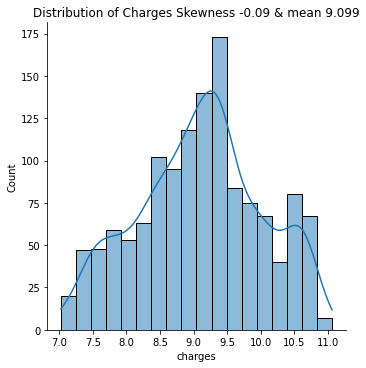

In [560]:
log_charge = np.log(data['charges'])
log_skew = round(log_charge.skew(), 3)
log_mean = round(log_charge.mean(), 3)

sns.displot(log_charge, kde=True);
plt.title(f'Distribution of Charges Skewness {log_skew} & mean {log_mean}');
print(f'Skewness {log_skew} & mean {log_mean}' );


# Log Model Simplification & BIC (Bayesian Information Criterion)

In [561]:
log_X_incl_const = sm.add_constant(log_X_train)
log_model = sm.OLS(log_y_train, log_X_incl_const)
log_results = log_model.fit()
log_model_rsquared = log_regr.score(log_X_test, log_y_test)
print('Results r-squared ', log_model_rsquared)
print('BIC ', log_results.bic)

Results r-squared  0.7996323002117187
BIC  1381.3495024856666


In [562]:
pd.DataFrame({'coef':regr.coef_, 'log_coef':log_regr.coef_}, index=features.columns)

,coef,log_coef
age,244.581639,0.033275
bmi,338.444612,0.014004
children,511.869435,0.101178
sex_male,-93.045165,-0.069171
smoker_yes,24000.548124,1.549917
region_northwest,-545.567916,-0.054020
region_southeast,-1238.683849,-0.148382
region_southwest,-1494.972657,-0.140642


# Log Model Residuals and Residual Plots

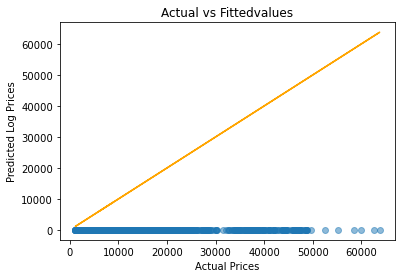

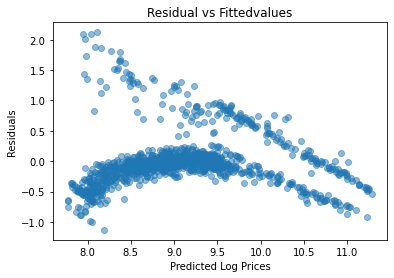

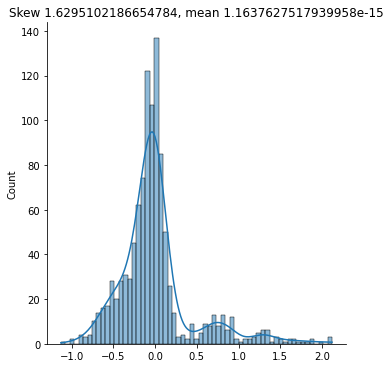

In [563]:
# actual vs predicted
plt.scatter(x=y_train, y=log_regr.predict(X_train), alpha=0.5);
plt.xlabel('Actual Prices');
plt.ylabel('Predicted Log Prices')
plt.plot(y_train,y_train, color='orange');
plt.title('Actual vs Fittedvalues')
plt.show();

# residuals vs fitted values (predicted)
plt.scatter(x=log_regr.predict(X_train), y=log_results.resid, alpha=0.5);
plt.xlabel('Predicted Log Prices');
plt.ylabel('Residuals')
plt.title('Residual vs Fittedvalues');
plt.show();

# skewness and mean
log_results_resid_skew = log_results.resid.skew()
log_results_resid_mean = log_results.resid.mean()
sns.displot(log_results.resid, kde=True);
plt.title(f'Skew {log_results_resid_skew}, mean {log_results_resid_mean}');

# Log Model Variance Inflation Factor 

In [564]:
vif = [variance_inflation_factor(exog=log_X_incl_const.values, 
                                 exog_idx=i) for i in range(log_X_incl_const.shape[1])]

pd.DataFrame({'coef_name': log_X_incl_const.columns, 
             'vif': np.around(vif, 2)})

,coef_name,vif
0,const,35.04
1,age,1.02
2,bmi,1.11
3,children,1.01
4,sex_male,1.01
5,smoker_yes,1.01
6,region_northwest,1.52
7,region_southeast,1.65
8,region_southwest,1.52


# Log Model MSE & RMSE

In [583]:
# mse base on test set
log_model_mse = mean_squared_error(log_y_train,log_regr.predict(log_X_train))
log_model_rmse = np.sqrt(log_model_mse)
log_model_mae = mean_absolute_error(log_y_test,log_regr.predict(log_X_test))

# log_model_mse = log_results.mse_resid
# print(f'Log Model MSE {log_results.mse_resid}')
print(f'Log Model MSE {round(log_model_mse, 3)}')
print(f'Log Model RMSE {round(log_model_rmse, 3)}')
print(f'Log Model MAE {round(log_model_mae, 3)}')
log_model_mse

Log Model MSE 0.201
Log Model RMSE 0.448
Log Model MAE 0.276


0.20077549631861022

# Log Model VIF

In [584]:
log_model_vif = 1/(1-log_results.rsquared)
round(log_model_vif, 3)

4.132

In [567]:
log_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     415.3
Date:                Tue, 27 Jul 2021   Prob (F-statistic):          1.56e-320
Time:                        23:08:58   Log-Likelihood:                -659.29
No. Observations:                1070   AIC:                             1337.
Df Residuals:                    1061   BIC:                             1381.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.0644      0.081     86.753      0.000       6.905       7.224
age                  0.0333      0.001     33.663      0.000       0.031       0.035
bmi                  0.0140      0.002      6.006      0.000       0.009       0.019
children             0.1012      0.011      8.997      0.000       0.079       0.123
sex_male            -0.0692      0.028     -2.503      0.012      -0.123      -0.015
smoker_yes           1.5499      0.034     45.310      0.000       1.483       1.617
region_northwest    -0.0540      0.039     -1.374      0.170      -0.131       0.023
region_southeast    -0.1484      0.040     -3.746      0.000      -0.226      -0.071
region_southwest    -0.1406      0.040     -3.529      0.000      -0.219      -0.062
==============================================================================
Omnibus:                      359.610   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1237.194
Skew:                           1.627   Prob(JB):                    2.22e-269
Kurtosis:                       7.142   Cond. No.                         312.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [576]:
rmse(log_y_train,log_results.fittedvalues)

0.44807978789341774

In [605]:
CV(LinearRegression(), log_features, log_charges, cv=10, n_jobs=10, scoring='r2').mean()

0.7613310449169256

In [608]:

CV(LinearRegression(), log_features, log_charges, cv=10, n_jobs=5, scoring='neg_mean_squared_error').mean()*-1



0.19879092054423841

In [609]:
CV(LinearRegression(), features, charges, cv=10, n_jobs=5, scoring='neg_mean_squared_error').mean()*-1


36990225.36687711

In [612]:
CV(XGBRegressor(n_estimators=1000, learning_rate=0.05), log_features, log_charges, cv=10, n_jobs=5, scoring='r2').mean()*-1


-0.7709287001172623

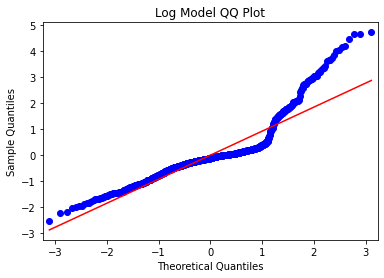

In [624]:
sm.qqplot(log_results.resid, fit=True, line='r')
plt.title('Log Model QQ Plot')
plt.show()